# **IBL brain-wide map dataset**

## **Overview**

### **The brain-wide map dataset**

The International Brain Laboratory (IBL) Brainwide Map project set out to map neural activity across the entire mouse brain at single-spike, cellular resolution during a standardized decision-making task. The resulting dataset has been made publicly available.

The dataset includes:


* Data collected across **12 laboratories**

* Recordings from **139 mice**

* A total of **459 behavioral sessions**

* **699 Neuropixels probe insertions**

* Coverage of **281 brain regions**

* **621,733 recorded neurons**, including

* **75,708 good neurons**


![](https://ibl-brain-wide-map-public.s3.us-east-1.amazonaws.com/sample_data/Neuromatch/figures/bwm_recordings.png)



### **Recording Plan**

Neural activity was recorded using Neuropixels probes, targeted according to a standardized grid system with insertion sites spaced 500 µm apart.

The recording system aimed to:
* Achieve uniform coverage across the brain

* Prioritize regions with known anatomical connectivity (e.g., the cerebellum and medulla were sampled from the right hemisphere)

* Replicate each recording site in at least two independent laboratories

* Evaluate the reproducibility of neural activity across subjects and experimental sites (via the "repeated site")

* Investigate bilateral and interhemispheric interactions (via the "bilateral sites")

![](https://ibl-brain-wide-map-public.s3.us-east-1.amazonaws.com/sample_data/Neuromatch/figures/bwm_plan.png)


### **Decision making task**

In the IBL decision making task a visual stimulus appears at the edge of the screen and mice must bring the stimulus to the screen centre by moving a wheel with their front two paws. If they successfully bring the stimulus to the screen centre, they receive a reward of sugar water ; if however they move the wheel in the wrong direction until the stimulus reaches beyond the screen edge, a white noise tone is played. To initiate a trial, the mouse must hold the wheel still for a continuous period between 0.4-0.7s ; they are then alerted of the start of the trial by the simultaneous presentation of the stimulus on the screen and a go cue tone. Mice have a maximum of 60s to make a decision before the trial times out and a white noise tone is played.

Varying contrasts of visual stimulus are shown throughout the session (100%, 25%, 12.5%, 6.25% and 0%). The probability of the stimulus appearing on the left or the right changes between blocks of trials. During 0% contrast trials (where no stimulus appears on the screen but a wheel response is required), the mice can use the inferred block structure to guide their decision.


![](https://ibl-brain-wide-map-public.s3.us-east-1.amazonaws.com/sample_data/Neuromatch/figures/task.png)


### **Accessing the data**
For the purposes of this course, we have precomputed task-aligned peri-stimulus time histograms (PSTHs) for all good clusters in the dataset. This allows you to quickly begin working with the data using a simplified and accessible format. The tutorial below is based on this preprocessed data.

To access the full dataset, including raw electrophysiology (action potential and LFP bands), spike sorting output, wheel movement, video recordings, and pose estimation data please refer to this [this introductary notebook](https://colab.research.google.com/drive/1_1qfa-DLDbezyFXguFOnJJWF5aJ5AH0i#scrollTo=-TJR7XEgtBxS) and [this tutorial](https://colab.research.google.com/drive/1y3sRI1wC7qbWqN6skvulzPOp6xw8tLm7#scrollTo=hRZA78AoaBIC).



> *All data are made available under the CC BY 4.0 license.*

## **1. Installation and setup**

The code blocks in this section install and import required packages. We also define a set of utility functions that will be used to download and load data throughout the rest of the tutorial. **Make sure these cells are run before continuing onto the next sections.**

### **Install dependencies**

In [ ]:
! pip install ONE-api --quiet
! pip install ibllib --quiet

### **Setup ONE**

In [ ]:
# When running in jupyter set number of threads to 1
import os
os.environ.setdefault('ONE_HTTP_DL_THREADS', '1')

from one.api import ONE
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"


### **Define imports**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pandas as pd
from scipy import sparse
import numpy as np
from one.remote.aws import s3_download_file
import zipfile
import tqdm
import scipy.stats as stats
from iblutil.util import Bunch
from scipy.ndimage import gaussian_filter1d

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# This is to view dataframe interactively in Google colab
if 'google.colab' in sys.modules:
    from google.colab import data_table
    data_table.enable_dataframe_formatter()

# This is to style figures
if sys.version_info >= (3, 10):
    from ibl_style.style import figure_style
    figure_style()

### **Define loading utility functions**

In [ ]:
def download_data(event):
  assert event in ['firstMove', 'stimOn', 'feedback'], 'event must be one of "firstMove", "stimOn" or "feedback'

  # Dataset name
  fname = f'data_{event}.zip'
  # Remote location of data
  s3_data_path = f'sample_data/Neuromatch/{fname}'
  # Local location to download data to
  save_path = one.cache_dir.joinpath('Neuromatch', fname)
  save_path.parent.mkdir(exist_ok=True, parents=True)

  # Download file
  file = s3_download_file(s3_data_path, save_path)
  # Unzip content
  with zipfile.ZipFile(file, 'r') as zip_ref:
    zip_ref.extractall(save_path.parent)


def get_data_path(event):

  return one.cache_dir.joinpath('Neuromatch', f'data_{event}')


def load_metadata(event):
  metadata = Bunch()
  data_path = get_data_path(event)
  metadata['clusters'] = pd.read_parquet(data_path.joinpath('clusters.pqt'))
  metadata['trials'] = pd.read_parquet(data_path.joinpath('trials.pqt'))
  metadata['sessions'] = pd.read_parquet(data_path.joinpath('sessions.pqt'))
  metadata['times'] = np.load(data_path.joinpath('t.npy'))
  metadata['nbins'] = metadata['times'].size
  metadata['dt'] = np.round(np.median(np.diff(metadata['times'])), 2)
  metadata['data_path'] = data_path

  return metadata


def load_times(data_path):
  return np.load(data_path.joinpath('t.npy'))


def load_psth(data_path, pid, nbins=150):
    psth = sparse.load_npz(data_path.joinpath(f'{pid}.npz')).toarray()
    psth = psth.reshape(psth.shape[0], -1, nbins)
    return psth

### **Define processing utility functions** <a name="Utility-functions"></a>

In [ ]:
def split_trials_by_variable(trials, split='contrast'):
  trials = trials.set_index('psth_index')
  if split == 'contrast':
    trials['contrast'] = np.nansum([trials['contrastLeft'], trials['contrastRight']], axis=0) * 100
    grp = trials.groupby('contrast')
  elif split == 'signed contrast':
    trials['signedContrast'] = np.nansum([-1 * trials['contrastLeft'], trials['contrastRight']], axis=0) * 100
    grp = trials.groupby('signedContrast')
  elif split == 'stimulus':
    trials['stimulus'] = 'right'
    trials.loc[trials['contrastRight'].isna(), 'stimulus'] = 'left'
    grp = trials.groupby('stimulus')
  elif split == 'choice':
    grp = trials.groupby('choice')
  elif split == 'block':
    grp = trials.groupby('probabilityLeft')
  else:
    raise NotImplementedError('split must be one of "contrast", "signed contrast", "stimulus", "choice" or "block"')

  return grp.groups


def get_avg_psth_for_insertion(pid, meta, reg=None, uuids=None, split=None):

  df = meta.clusters[meta.clusters['pid'] == pid]
  df = df[['acronym', 'pid', 'uuids', 'cluster_id', 'psth_index']]
  sp = load_psth(meta.data_path, pid, nbins=meta.nbins)

  if reg is not None:
    in_reg = df['acronym'] == reg
    sp = sp[:, in_reg.values, :]
    df = df[in_reg].reset_index(drop=True)

  if uuids is not None:
    in_uuid = df['uuids'].isin(uuids)
    sp = sp[:, in_uuid.values, :]
    df = df[in_uuid].reset_index(drop=True)

  if split is None:
    psth = sp.mean(axis=0) / meta['dt']
  else:
    psth = dict()
    eid = meta.sessions[meta.sessions['pid'] == pid].iloc[0]['eid']
    trials = meta.trials[meta.trials['eid'] == eid].reset_index(drop=True)
    grps = split_trials_by_variable(trials, split=split)

    for key, vals in grps.items():
      psth[key] = sp[vals, :, :].mean(axis=0)

  return psth, df

def get_avg_psth_for_region(reg, meta, split=None):
  clusters = meta.clusters[meta.clusters['acronym'] == reg]
  pids = clusters['pid'].unique()
  all_df = []
  all_psth = []
  for pid in pids:
    psth, df = get_avg_psth_for_insertion(pid, meta, reg=reg, split=split)
    all_df.append(df)
    all_psth.append(psth)

  all_df = pd.concat(all_df).reset_index(drop=True)
  if split is None:
    all_psth = np.concatenate(all_psth)
  else:
    all_psth = {key: np.concatenate([d[key] for d in all_psth if key in d.keys()])
    for key in all_psth[0]}


  return all_psth, all_df


def get_avg_psth_for_clusters(uuids, meta, split=None):
  clusters = meta.clusters[meta.clusters['uuids'].isin(uuids)]
  pids = clusters['pid'].unique()
  all_df = []
  all_psth = []
  for pid in pids:
    psth, df = get_avg_psth_for_insertion(pid, meta, uuids=uuids, split=split)
    all_df.append(df)
    all_psth.append(psth)

  all_df = pd.concat(all_df).reset_index(drop=True)
  if split is None:
    all_psth = np.concatenate(all_psth)
  else:
    all_psth = {key: np.concatenate([d[key] for d in all_psth if key in d.keys()])
    for key in all_psth[0]}

  return all_psth, all_df



def get_psth_for_insertion(pid, meta, reg=None, uuids=None):

  df = meta.clusters[meta.clusters['pid'] == pid]
  df = df[['acronym', 'pid', 'uuids', 'cluster_id', 'psth_index']]
  sp = load_psth(meta.data_path, pid, nbins=meta.nbins)

  if reg is not None:
    in_reg = df['acronym'] == reg
    sp = sp[:, in_reg.values, :]
    df = df[in_reg].reset_index(drop=True)

  if uuids is not None:
    in_uuid = df['uuids'].isin(uuids)
    sp = sp[:, in_uuid.values, :]
    df = df[in_uuid].reset_index(drop=True)


  eid = meta.sessions[meta.sessions['pid'] == pid].iloc[0]['eid']
  trials = meta.trials[meta.trials['eid'] == eid].reset_index(drop=True)
  psth = sp / meta['dt']

  return psth, df, trials


def get_psth_for_region(reg, meta):

  clusters = meta.clusters[meta.clusters['acronym'] == reg]
  pids = clusters['pid'].unique()
  all_clust = []
  all_psth = []
  all_trials = []
  for pid in pids:
    psth, clust, trials = get_psth_for_insertion(pid, meta, reg=reg)
    all_clust.append(clust)
    all_psth.append(psth)
    all_trials.append(trials)

  return all_psth, all_clust, all_trials


def get_psth_for_clusters(uuids, meta):

  clusters = meta.clusters[meta.clusters['uuids'].isin(uuids)]
  pids = clusters['pid'].unique()
  all_clust = []
  all_psth = []
  all_trials = []
  for pid in pids:
    psth, clust, trials = get_psth_for_insertion(pid, meta, uuids=uuids)
    all_clust.append(clust)
    all_psth.append(psth)
    all_trials.append(trials)

  return all_psth, all_clust, all_trials

## **2. Data Access**
In this section we will show how to **download and load the preprocessed data** and walk through the **structure and content of the data** to help you become familiar with its organisation and key components.

### **Data Format**
To facilitate analysis, we have prepared three ZIP files containing data aligned to different key task events:

* `data_stimOn.zip` — aligned to **stimulus onset**, the moment the visual stimulus appears on the screen

* `data_firstMove.zip` — aligned to the **first movement**, when the mouse initiates a wheel turn that moves the stimulus past threshold

* `data_feedback.zip` — aligned to **feedback time**, when the mouse receives feedback based on its choice


Each ZIP archive contains the following files:

* `clusters.pqt` — metadata for each recorded cluster (e.g. brain region)

* `trials.pqt` — behavioral trial data (e.g. stimulus, choice, contrast)

* `sessions.pqt` — metadata for each recording session (e.g. subject, lab)

* `t.npy` — timepoints for the peri-stimulus time histogram (PSTH); spans from -0.5 s to +1.0 s around the event in 10 ms steps

* `{pid}.npz` — PSTH data for each individual probe insertion, labeled by its unique probe ID (pid)


🔍 What are eid and pid?

Throughout the dataset and code, you will encounter two key identifiers:

* `eid` — the experiment/session ID, uniquely identifying each behavioral session

* `pid` — the probe insertion ID, uniquely identifying each Neuropixels insertion

A single eid may be associated with multiple pids, since several probes can be recorded from during the same session.

### **Downloading the data**

The data for a given aligned event can be downloaded in the following way.

In [ ]:
download_data('stimOn')

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/Neuromatch/data_stimOn.zip: 100%|██████████| 810M/810M [00:11<00:00, 70.1MB/s]


### **Loading metadata**
We can load all of the metadata (cluster, trial, session and timestamps data) in the following way.

In [ ]:
meta = load_metadata('stimOn')
print(f'Meta data contains the following keys: {list(meta.keys())}')

Meta data contains the following keys: ['clusters', 'trials', 'sessions', 'times', 'nbins', 'dt', 'data_path']


**Clusters**

The `clusters.pqt` table contains metadata for each cluster in the dataset. Key columns include:

* `acronym`: Brain region label for the cluster, based on the Allen CCF annotation

* `pid`: Probe insertion ID indicating which Neuropixels probe the cluster was recorded from

* `psth_index`: Index into the PSTH array for the corresponding pid (clusters are along the first dimension)

* `cluster_id`: Cluster identifier used for linking to the IBL visualization website (unique within a pid)

* `uuids`: Unique identifier for each cluster






In [ ]:
meta.clusters[0:100]

,psth_index,uuids,cluster_id,firing_rate,x,y,z,atlas_id_allen,pid,acronym,acronym_allen
0,0,c7d051dc-1358-422d-9eab-ca13c6b6be1b,2,2.831652,-0.002289,-0.002537,-0.003595,549,56f2a378-78d2-4132-b3c8-8c1ba82be598,root,TH
1,1,38bc27f2-7301-405a-a870-54e0a7b06a26,15,6.941674,-0.002289,-0.002533,-0.003576,549,56f2a378-78d2-4132-b3c8-8c1ba82be598,root,TH
2,2,1c4e5e11-ca9d-441a-bb8f-4b56dcc95054,22,2.702620,-0.002289,-0.002528,-0.003556,549,56f2a378-78d2-4132-b3c8-8c1ba82be598,root,TH
3,3,b48a90ed-84f4-424d-87ae-92c22a423777,23,5.210307,-0.002289,-0.002528,-0.003556,549,56f2a378-78d2-4132-b3c8-8c1ba82be598,root,TH
4,4,38a812b9-b374-46f8-ab14-3dd146411fc8,26,10.565215,-0.002289,-0.002528,-0.003556,549,56f2a378-78d2-4132-b3c8-8c1ba82be598,root,TH
...,...,...,...,...,...,...,...,...,...,...,...
95,19,e28cfb7c-0643-4473-9fef-3433911ec373,123,6.504648,-0.002971,-0.001782,-0.006251,334,47be9ae4-290f-46ab-b047-952bc3a1a509,BMA,BMAp
96,20,b3b657e3-f6b4-4c13-9b55-58e4f220fb64,125,3.412639,-0.002971,-0.001782,-0.006251,334,47be9ae4-290f-46ab-b047-952bc3a1a509,BMA,BMAp
97,21,4b5bf195-0527-445e-a879-dcffa8072131,127,1.272447,-0.002966,-0.001777,-0.006232,334,47be9ae4-290f-46ab-b047-952bc3a1a509,BMA,BMAp
98,22,f1984098-82db-437a-817d-6c0ef122af9b,130,7.866468,-0.002966,-0.001777,-0.006232,334,47be9ae4-290f-46ab-b047-952bc3a1a509,BMA,BMAp


**Trials**

The `trials.pqt` table contains metadata for each behavioral trial in the dataset. Key columns include:

* `eid`: Experiment/session ID indicating which session the trial belongs to

* `psth_index`: Index into the PSTH array for the corresponding pid (trials are along the first dimension)

* `probabilityLeft`: Probability that the visual stimulus would appear on the left side of the screen

* `feedbackType`: Indicates trial outcome, 1 for correct, -1 for incorrect

* `contrastLeft`: Contrast of the visual stimulus when presented on left; nan values indicate contrast was shown on right hand side of screen

* `contrastRight`: Contrast of the visual stimulus when presented on right; nan values indicate contrast was shown on left hand side of screen

* `choice`: Mouse's choice, 1 for clockwise wheel turn (typically indicating a rightward choice), -1 for anticlockwise turn (leftward choice)

* `block`: The block number number of the trial

* `block_trial_number`: The index of the trial relative to the most recent block switch (i.e., trial number within the current block)

In [ ]:
meta.trials[0:100]

,eid,probabilityLeft,feedbackType,contrastLeft,contrastRight,choice,psth_index,block,block_trial_number
0,6713a4a7-faed-4df2-acab-ee4e63326f8d,0.5,1.0,0.125,NaN,1.0,0,0,9
1,6713a4a7-faed-4df2-acab-ee4e63326f8d,0.5,-1.0,NaN,0.250,1.0,1,0,12
2,6713a4a7-faed-4df2-acab-ee4e63326f8d,0.5,-1.0,NaN,0.250,1.0,2,0,14
3,6713a4a7-faed-4df2-acab-ee4e63326f8d,0.5,1.0,0.250,NaN,1.0,3,0,16
4,6713a4a7-faed-4df2-acab-ee4e63326f8d,0.5,-1.0,NaN,0.125,1.0,4,0,19
...,...,...,...,...,...,...,...,...,...
95,6713a4a7-faed-4df2-acab-ee4e63326f8d,0.2,1.0,NaN,0.000,-1.0,95,2,18
96,6713a4a7-faed-4df2-acab-ee4e63326f8d,0.2,1.0,NaN,0.250,-1.0,96,2,19
97,6713a4a7-faed-4df2-acab-ee4e63326f8d,0.2,1.0,NaN,0.125,-1.0,97,2,20
98,6713a4a7-faed-4df2-acab-ee4e63326f8d,0.2,1.0,NaN,0.250,-1.0,98,2,21


**Sessions**

The `sessions.pqt` table contains metadata for each recording session and serves as a link between the clusters and trials tables via the `eid` and `pid` columns.

Key columns include:

* `lab`: Name of the lab where the recording was performed

* `subject`: Identifier for the mouse used in the session

* `eid`: Experiment/session ID; multiple probe insertions (pids) with the same eid were recorded simultaneously during a single behavioral session

* `pid`: Probe insertion ID corresponding to a specific Neuropixels probe used during the session




In [ ]:
meta.sessions

,pid,eid,probe_name,session_number,date,subject,lab
0,56f2a378-78d2-4132-b3c8-8c1ba82be598,6713a4a7-faed-4df2-acab-ee4e63326f8d,probe00,1,2020-02-18,NYU-11,angelakilab
1,47be9ae4-290f-46ab-b047-952bc3a1a509,56956777-dca5-468c-87cb-78150432cc57,probe01,1,2020-02-21,NYU-11,angelakilab
2,6be21156-33b0-4f70-9a0f-65b3e3cd6d4a,56956777-dca5-468c-87cb-78150432cc57,probe00,1,2020-02-21,NYU-11,angelakilab
3,8dfb86c8-d45c-46c4-90ec-33078014d434,4364a246-f8d7-4ce7-ba23-a098104b96e4,probe01,1,2020-01-20,NYU-12,angelakilab
4,c893c0a3-5597-49cf-baa1-60efdfdef542,b182b754-3c3e-4942-8144-6ee790926b58,probe01,1,2020-01-21,NYU-12,angelakilab
...,...,...,...,...,...,...,...
694,8bf0f1a4-0d8c-4df3-a99e-f7c81c809652,993c7024-0abc-4028-ad30-d397ad55b084,probe01,1,2020-09-16,CSH_ZAD_029,zadorlab
695,5d570bf6-a4c6-4bf1-a14b-2c878c84ef0e,fece187f-b47f-4870-a1d6-619afe942a7d,probe01,1,2020-09-17,CSH_ZAD_029,zadorlab
696,f7c93877-ec05-4091-a003-e69fae0f2fa8,fece187f-b47f-4870-a1d6-619afe942a7d,probe00,1,2020-09-17,CSH_ZAD_029,zadorlab
697,675952a4-e8b3-4e82-a179-cc970d5a8b01,c7bd79c9-c47e-4ea5-aea3-74dda991b48e,probe01,1,2020-09-19,CSH_ZAD_029,zadorlab


**Times, nbins and dt**

*   `times`: An array representing the specific time points at which the PSTH is computed
*   `nbins`: The number of bins used in the PSTH
*   `dt`: The interval between the time points, used to convert spike counts stored in the PSTH arrays into firing rate

In [ ]:
print(f'Times array: {meta.times[0]} s to {meta.times[-1]} s')
print(f'nbins: {meta.nbins}')
print(f'dt: {meta.dt} s')

Times array: -0.495 s to 0.995 s
nbins: 150
dt: 0.01 s


### **Loading PSTH data**
The PSTH for a given probe insertion alongside the metadata for the specified pid can be loaded in the following way.

In [ ]:
pid = '69f42a9c-095d-4a25-bca8-61a9869871d3'
psth, cluster_pid, trial_pid = get_psth_for_insertion(pid, meta)

The `psth` has dimensions `n_trials x n_clusters x n_times`

In [ ]:
psth.shape

(437, 101, 150)

The trials metadata `trial_pid` contains information about the trials stored in the PSTH array. The column `psth_index` directly indexes into the 0th dimension of the `psth` array

In [ ]:
print(f'Shape of 0th dimension of psth array: {psth.shape[0]}')
print(f'Length of trial_pid {len(trial_pid)}')

Shape of 0th dimension of psth array: 437
Length of trial_pid 437


The cluster metadata `cluster_pid` contains information about the clusters stored in the PSTH array. The column `psth_index` directly indexes into the 1st dimension of the `psth` array

In [ ]:
print(f'Shape of 1st dimension of psth array: {psth.shape[1]}')
print(f'Length of cluster_pid {len(cluster_pid)}')

Shape of 1st dimension of psth array: 101
Length of cluster_pid 101


## **3. Exploring the metadata**
In this section we explore the **metadata** to get a handle of the **scope of the data** that we have available.

In [ ]:
# Find the number of labs the data comes from
print(f"Number of labs: {len(meta.sessions['lab'].unique())}")

Number of labs: 12


In [ ]:
# Find the number of probe insertions we have
print(f"Number of probe insertions: {len(meta.sessions['pid'].unique())}")

Number of probe insertions: 699


In [ ]:
# Find the number of good clusters
print(f"Number of good clusters: {len(meta.clusters['cluster_id'])}")

Number of good clusters: 75708


In [ ]:
# Find the number of brain regions
print(f"Number of brain_regions: {len(meta.clusters['acronym'].unique())}")

Number of brain_regions: 268


## **4. Exploring stimulus aligned data**

In this section, we will examine neural activity aligned to **stimulus onset**. You will be introduced to a set of helper functions that make it easy to compute **trial-averaged PSTHs** for clusters across insertions and brain regions. Using these tools, we will explore ways to detect **stimulus-responsive cells** and determine the **latency** of their responses.

### **Exploring the visualisation website**

To get started, we can explore the IBL brainwide map [visualisation website](https://viz.internationalbrainlab.org/app?spikesorting=ss_2024-05-06) and look for insertions that contain clusters that respond to the task stimulus.


🕵 Hint:
*   You can search by a **pid** directly in the website's search bar.
*   You can also search by **brain region acronym**, such as `region:VISam` for visual cortex, where stimulus-responsive clusters are expected based on prior literature.

Here is an example cluster: [link to the website](https://viz.internationalbrainlab.org/app?spikesorting=ss_2024-05-06&dset=rs&pid=f86e9571-63ff-4116-9c40-aa44d57d2da9&tid=0&cid=-1&qc=0)

* pid: `0393f34c-a2bd-4c01-99c9-f6b4ec6e786d`
* cluster id: `779`

This cluster is in VISpm5, we can appreciate it has a sharp response to the visual stimulus (see plot C), a classic spike waveform (see plot F) and sustained activity throughout the session (see plot J).


![](https://ibl-brain-wide-map-public.s3.us-east-1.amazonaws.com/sample_data/Neuromatch/figures/viz_website_example.png)

### **Exploring data for a specific insertion**

To load data for a chosen probe insertion, we can use the helper function **`get_avg_psth_for_insertion`** defined in the [installation section](#Utility-functions). This function loads **trial-averaged PSTHs for each cluster** and returns:

1. A 2D array of shape `n_clusters x n_times` containing the trial averaged PSTH for the specified pid

2. A dataframe describing the clusters for the specified pid

For example, let's load data for the insertion with the responsive cell above

In [ ]:
pid = '0393f34c-a2bd-4c01-99c9-f6b4ec6e786d'
psth, df = get_avg_psth_for_insertion(pid, meta)

We can find the regions that this probe insertion recorded from

In [ ]:
df.acronym.value_counts()

,count
acronym,
VISpm,43
APN,30
VISam,17
CA1,13
root,8
MRN,6
DG,5


And then plot the trial-averaged PSTHs for all clusters in a specific region, such as VISam

Text(0, 0.5, 'Firing rate (Hz)')

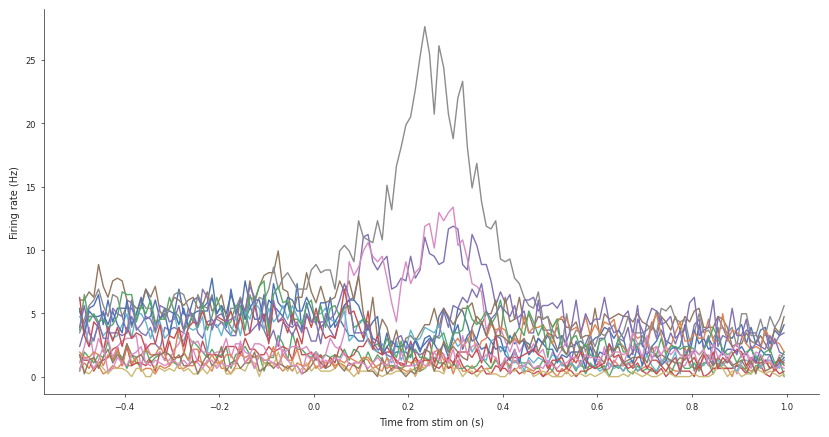

In [ ]:
idx_reg = df['acronym'] == 'VISam'
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(meta['times'], psth[idx_reg, :].T)
ax.set_xlabel('Time from stim on (s)')
ax.set_ylabel('Firing rate (Hz)')

### **Identifying responsive cells**

To find **stimulus-responsive cells**, we can **compare the firing rates** of the clusters in defined **pre and post-stimulus time windows**. Here, we use a 50 ms window before the stimulus onset (-0.3 to -0.25 s) and a 50 ms window after (0.05 to 0.1 s):

In [ ]:
pre_time = [-0.3, -0.25]
post_time = [0.05, 0.1]
pre_time_idx = np.bitwise_and(meta['times'] >= pre_time[0], meta['times'] <= pre_time[1])
post_time_idx = np.bitwise_and(meta['times'] >= post_time[0], meta['times'] <= post_time[1])

We can then compute the **average firing rate of the PSTH** in these two intervals and add them as new columns to our DataFrame.

In [ ]:
df['pre'] = np.mean(psth[:, pre_time_idx], axis=1)
df['post'] = np.mean(psth[:, post_time_idx], axis=1)

To identify responsive units, we will compute the **modulation index (MI)**. The formula is:

$$
MI = \frac{\left| \text{pre} - \text{post} \right|}{\left| \text{pre} + \text{post} \right|}
$$

where $\text{pre}$ is the value before the event, and $\text{post}$ is the value after the event.

🟨 **Note:**

*   We are taking the absolute value at the top, so we will not be able to differentiate if a cluster decreases or increases its activity -  we will only be able to state that the difference in activity between pre and post is large.
*   There are other methods to assess whether a cluster is responsive. For example, you could do a paired t-test on the activity at each trial pre/ post and measure whether the response is significantly different.




In [ ]:
df['modulation_idx'] = (df['pre'] - df['post']).abs() / (df['pre'] + df['post']).abs()

We can plot the modulation index for the clusters

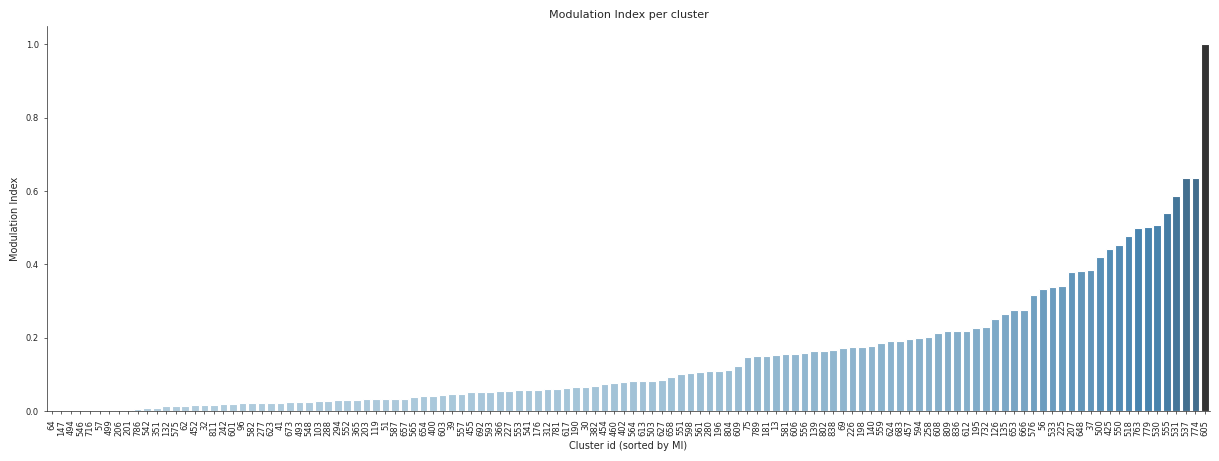

In [ ]:
# Sort cluster IDs by modulation index for plotting
df['ordered_clusters'] = df['cluster_id'].values[df['modulation_idx'].values.argsort()]

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df, x='cluster_id', y='modulation_idx', order=df['ordered_clusters'].values,
            palette='Blues_d', hue='modulation_idx', legend=False, ax=ax)

ax.set_xlabel('Cluster id (sorted by MI)')
ax.set_ylabel('Modulation Index')
ax.set_title('Modulation Index per cluster')
ax.tick_params(axis='x', rotation=90)

🟨 **Note:**

*   Some clusters do not have any bars - these are the ones where the denominator is 0, thus the MI = NaN.
*   The clusters with MI = 1 are clusters that had no firing rate in one of the two windows.


Let's assume that the responsive cells are the ones at the top of the distribution, e.g. **the 95th percentile**.


In [ ]:
# Calculate the 95th percentile of the modulation index
percentile_95 = df['modulation_idx'].quantile(0.95)

# Filter clusters with modulation index >= 95th percentile and those less than 1
high_mi_clusters = df[np.bitwise_and(df['modulation_idx'] >= percentile_95, df['modulation_idx'] < 1)]

# Store the index of the modulated clusters
modulated_clusters = high_mi_clusters['psth_index'].values

We can display the information about these **high modulation index clusters** and also plot their PSTHs.

In [ ]:
# Display the result
print("Clusters with modulation index in the 95th percentile or higher:")
high_mi_clusters

Clusters with modulation index in the 95th percentile or higher:


,acronym,pid,uuids,cluster_id,psth_index,pre,post,modulation_idx,ordered_clusters
8008,VISpm,0393f34c-a2bd-4c01-99c9-f6b4ec6e786d,ebcf8d49-7b96-40ee-b085-51cd82f70aad,530,60,3.930886,12.051836,0.508108,402
8009,VISpm,0393f34c-a2bd-4c01-99c9-f6b4ec6e786d,150b3cef-8333-4309-8368-75edcbf5af0e,531,61,2.203024,8.466523,0.587045,564
8011,VISpm,0393f34c-a2bd-4c01-99c9-f6b4ec6e786d,a733c417-60b3-4a62-a586-7c61cb11a599,537,63,0.086393,0.388769,0.636364,503
8020,VISpm,0393f34c-a2bd-4c01-99c9-f6b4ec6e786d,8842a421-1473-4959-bde3-3c1b95032d4d,555,72,4.017279,13.434125,0.539604,609
8059,VISpm,0393f34c-a2bd-4c01-99c9-f6b4ec6e786d,dae1a406-3fc8-4cbe-80b7-21f59c9b88c0,774,111,0.388769,0.086393,0.636364,425
8060,VISpm,0393f34c-a2bd-4c01-99c9-f6b4ec6e786d,5b4b484e-d4c8-40c7-a6e7-84213ca91dd1,779,112,3.369330,10.151188,0.501597,550


Text(0, 0.5, 'Firing rate (Hz)')

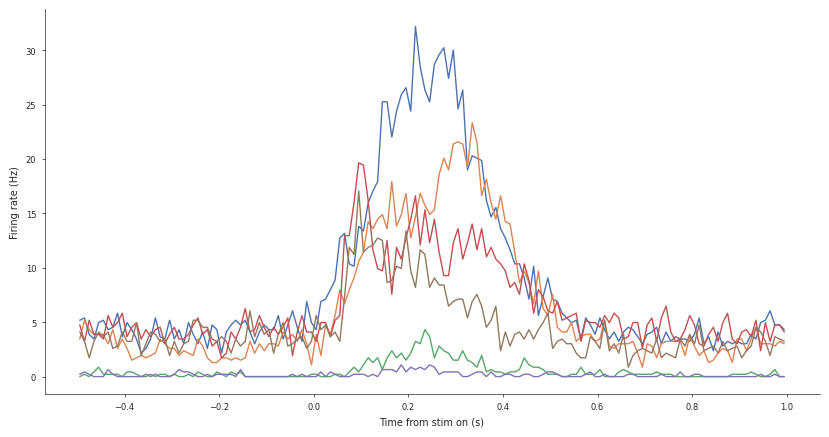

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(meta['times'], psth[high_mi_clusters['psth_index'].values, :].T)
ax.set_xlabel('Time from stim on (s)')
ax.set_ylabel('Firing rate (Hz)')

### **Detecting the latency of response**

We can explore the latency of the response by identifying the **timepoint of the peak response** following stimulus onset. Here we will apply a gaussian filter to the PSTH signal and estimate the latency as the peak of the response post stimlus onset, i.e **t > 0 s**.

Let's compute the latency of the response for the modulated clusters in the previous section.

In [ ]:
psth_mod = psth[modulated_clusters, :]
psth_filt = gaussian_filter1d(psth[modulated_clusters, :], sigma=1)

time_window = meta.times > 0
latency = np.argmax(psth_filt[:, time_window], axis=1)
latency_time = meta.times[time_window][latency]

high_mi_clusters = high_mi_clusters.assign(latency=latency_time)

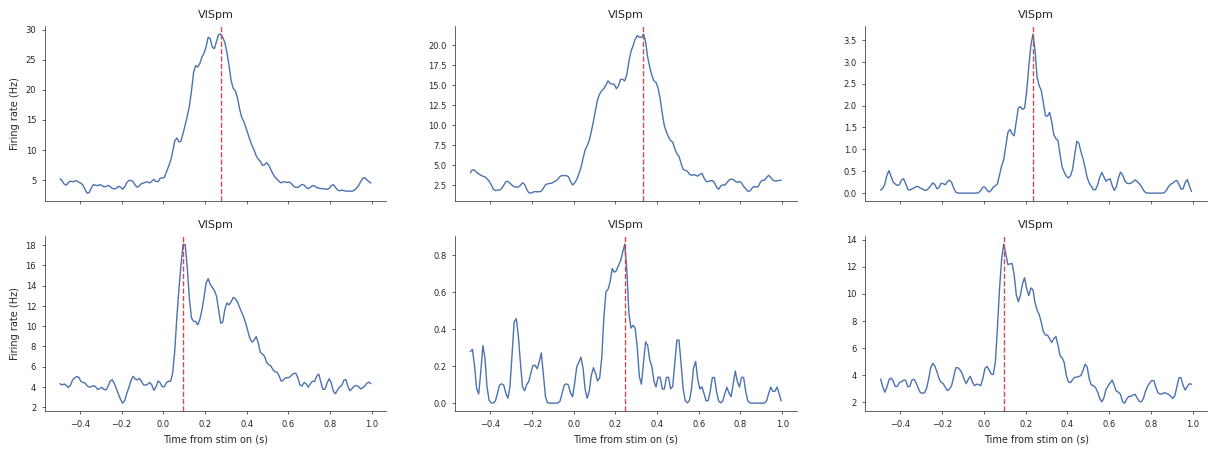

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 5), sharex=True)
axs = axs.ravel()
for i, mod in enumerate(psth_filt):
  axs[i].plot(meta.times, mod)
  axs[i].axvline(latency_time[i], linestyle='--', c='r')
  axs[i].set_title(high_mi_clusters.iloc[i]['acronym'])
  if i > 2:
    axs[i].set_xlabel('Time from stim on (s)')
  if i in [0, 3]:
    axs[i].set_ylabel('Firing rate (Hz)')

We can explore the **mean latency per region** by grouping our DataFrame by region.

In [ ]:
high_mi_clusters.groupby('acronym')['latency'].mean()

,latency
acronym,
VISpm,0.213333


### **Splitting responses by trial type**

In the examples above we computed the firing rate averaged across all trials. However, we can also split by **trial type** to see how the PSTH varies.

For example, we can split by **stimulus** side, i.e whether the stimulus was shown on the left or right of the screen. To do this we add an extra argument to the `get_avg_psth_for_insertion` function called **`split`**


In [ ]:
psth, df = get_avg_psth_for_insertion(pid, meta, split='stimulus')

In this case `psth` is returned as a dict that contains the averaged PSTH for each cluster for the different trial conditions, e.g left and right stimulus.

In [ ]:
print(f'keys in psth are {psth.keys()}')

keys in psth are dict_keys(['left', 'right'])


For the responsive cells that we identified above, we can plot the PSTH response for the different stimulus sides.

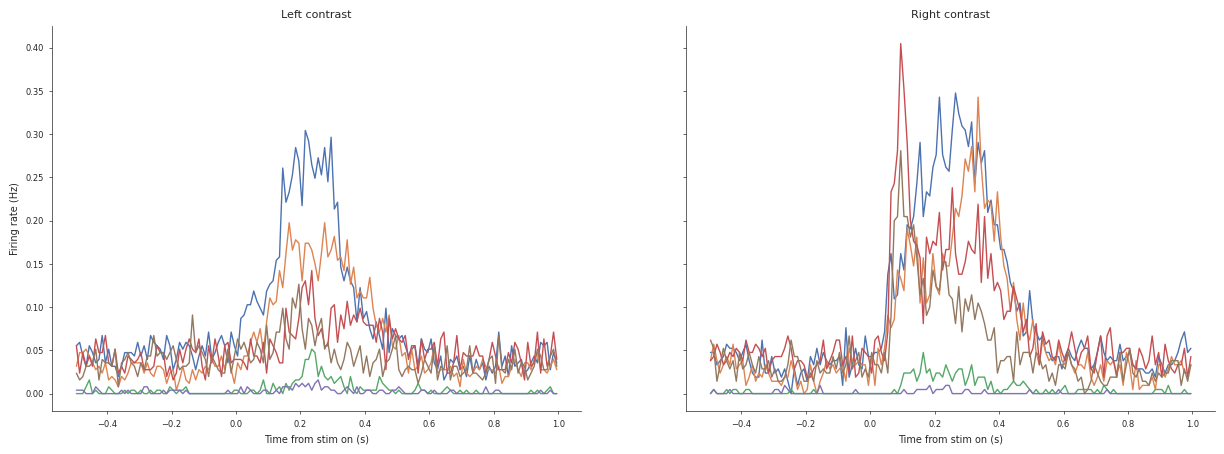

In [ ]:
fig, axs = plt.subplots(1, len(psth), figsize=(15, 5), sharey=True)
for i, (key, vals) in enumerate(psth.items()):
  axs[i].plot(meta['times'], psth[key][modulated_clusters, :].T)
  axs[i].set_title(f'{key.capitalize()} contrast')
  axs[i].set_xlabel('Time from stim on (s)')
  if i == 0:
    axs[i].set_ylabel('Firing rate (Hz)')

We can also split by stimulus **contrast**.

In [ ]:
psth, df = get_avg_psth_for_insertion(pid, meta, split='contrast')

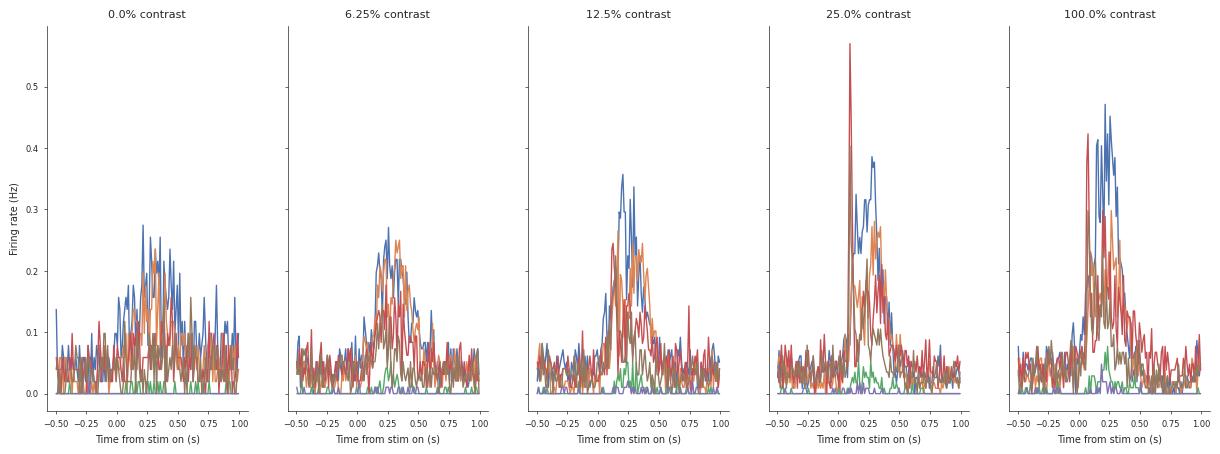

In [ ]:
fig, axs = plt.subplots(1, len(psth), figsize=(15, 5), sharey=True)
for i, (key, vals) in enumerate(psth.items()):
  axs[i].plot(meta['times'], psth[key][modulated_clusters, :].T)
  axs[i].set_title(f'{key}% contrast')
  axs[i].set_xlabel('Time from stim on (s)')
  if i == 0:
    axs[i].set_ylabel('Firing rate (Hz)')

Other options for the **`split`** argument are:
* **`signedContrast`** - combines stimulus side and contrast, negative values indicate the stimulus was shown on the left, positive values on the right
* **`choice`** - whether the mouse turned the wheel clockwise or anti-clockwise
* **`block`** - the probability of the stimulus appearing on the left or the right of the screen

### **Aggregating data across multiple insertions**


In the examples above, we explored how to analyse data from a single insertion. However, the real strength of the brain-wide map dataset lies in its coverage of **many insertions across the brain**. This allows us to pool data from multiple probes and animals, enabling us to explore activity at the **regional level**. In this section, we'll demonstrate how to combine data across insertions to investigate region-wide responses.

Let's explore activity in the region **VISam**. We are going to pool data for VISam from multiple probe insertions.

For this we have a helper function **`get_avg_psth_for_region`**. This behaves in the same way as `get_avg_psth_for_insertion` that we have been using above, but instead of passing in a `pid`, we pass in a **`region`**

In [ ]:
psth, df = get_avg_psth_for_region('VISam', meta)
print(f'{len(df)} clusters from {df["pid"].nunique()} insertions')

374 clusters from 23 insertions


Similar to above we can compute the **modulation index** to identify **responsive cells**.

In [ ]:
df['pre'] = np.mean(psth[:, pre_time_idx], axis=1)
df['post'] = np.mean(psth[:, post_time_idx], axis=1)
df['modulation_idx'] = (df['pre'] - df['post']).abs() / (df['pre'] + df['post']).abs()

idx_mod = np.bitwise_and(df['modulation_idx'] > 0.3, df['modulation_idx'] < 1)
print(f'{idx_mod.sum()}/{len(idx_mod)} of clusters are modulated')

87/374 of clusters are modulated


We can plot the PSTH of the modulated clusters as well as the average across all modulated clusters

Text(0, 0.5, 'Firing rate (Hz)')

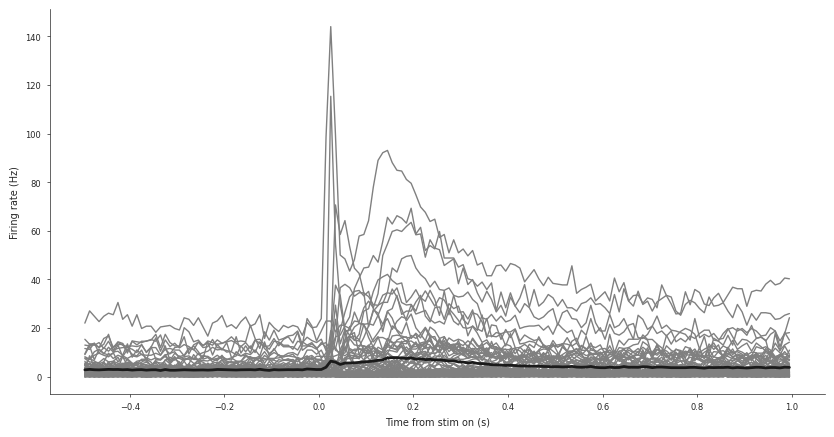

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(meta['times'], psth[idx_mod, :].T, c='grey')
ax.plot(meta['times'], psth[idx_mod, :].mean(axis=0), c='k', lw=2)
ax.set_xlabel('Time from stim on (s)')
ax.set_ylabel('Firing rate (Hz)')

If we now only want to explore the trial dependent response specifically for the modulated clusters that we have found, we can use a third helper function **`get_avg_psth_for_clusters`**. This function allows you to pass in a set of **cluster uuids** to compute the PSTH values.

For instance, if we've already identified clusters in VISam that are significantly modulated by stimulus onset, we can now investigate whether their responses differ depending on the **stimulus side**. The unique identifier for each cluster is stored in the **`uuids`** column.

In [ ]:
uuids = df.loc[idx_mod].uuids.values
psth_test, df_test = get_avg_psth_for_clusters(uuids, meta, split='stimulus')

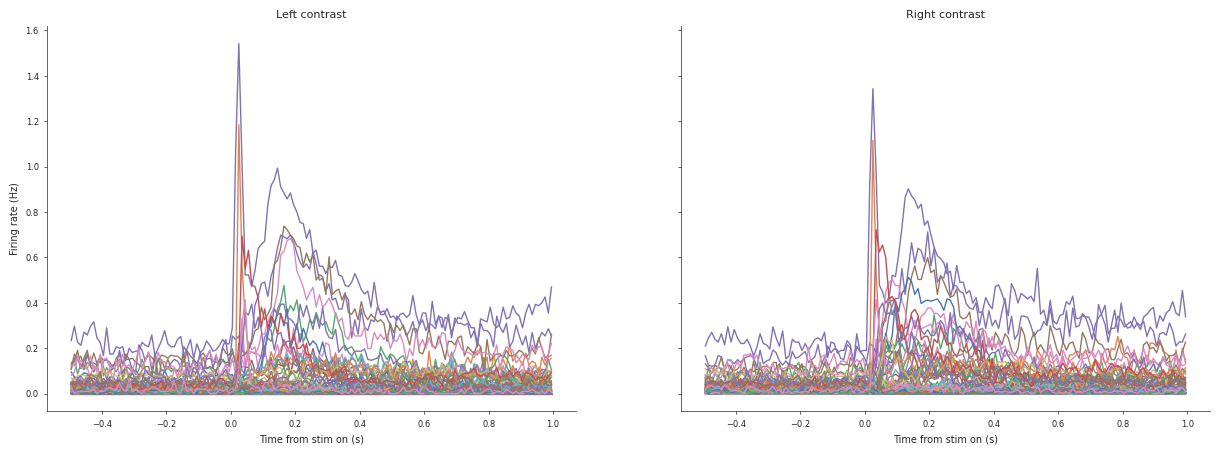

In [ ]:
fig, axs = plt.subplots(1, len(psth_test), figsize=(15, 5), sharey=True)
for i, (key, vals) in enumerate(psth_test.items()):
  axs[i].plot(meta['times'], psth_test[key].T)
  axs[i].set_title(f'{key.capitalize()} contrast')
  axs[i].set_xlabel('Time from stim on (s)')
  if i == 0:
    axs[i].set_ylabel('Firing rate (Hz)')

## **5. Exploring movement aligned data**

In the previous section, we analysed neural responses aligned to stimulus onset. However, we have also prepared a dataset with PSTHs aligned to the onset of the mouse's **first movement**. This alignment enables us to examine neural activity associated with  **choice** i.e. whether it chooses to turn the wheel left or right in response to the stimulus.

### **Downloading and loading in data for movement onset**

In [ ]:
# Download the data
download_data('firstMove')
# Load in the metadata
meta = load_metadata('firstMove')

### **Analyzing choice related neural activity using PCA**

One analysis that we can perform is to examine **when** the neural activity representing left versus right choices begins to diverge before the first movement is made. We will use a dimensionality reduction approach (PCA) to measure the **distance between the left and right choice representations** over a time window of interest.


We start by loading data from a specific brain region of interest, **GRN**. The trials are then split based on the **choice** made.

In [ ]:
# Look at example region. We want to split by choice
psth, df = get_avg_psth_for_region('GRN', meta, split='choice')

We will then construct a high-dimensional representation of the neural activity by **stacking the average PSTHs** from each cluster. Here, each dimension corresponds to one cluster’s activity.

Since we are interested in the time before the first movement, we restrict our analysis to the time window where **t < 0 s**.

In [ ]:
# Stack PSTHs for right (1, CW) and left (-1, CCW) choice
time_window = meta.times < 0
all_psth = np.concatenate([psth[1.0][:, time_window], psth[-1.0][:, time_window]], axis=1)

We then apply PCA to reduce the dimensionality of the neural data to **two principal components** and extract the trajectories for left and right choice.

In [ ]:
# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
trajs = pca.fit_transform(all_psth.T).T

# Extract trajectories for left and right choice
traj_right = trajs[:, :time_window.sum()]
traj_left = trajs[:, time_window.sum():]

To quantify how the neural representations for the two choices diverge over time, we compute the **Euclidean distance** between their trajectories at each time point.

In [ ]:
euc_dist = np.sqrt(np.sum((traj_left - traj_right) ** 2, axis=0))

We can estimate the **latency** at which the trajectories diverge as the time point at which the Euclidean distance is **70% of it's maximum value**.

In [ ]:
latency_idx = np.argmax(euc_dist > np.max(euc_dist) * 0.7)
latency = meta.times[time_window][latency_idx]

We can visualize both the low-dimensional trajectories and the evolution of their Euclidean distance leading up to the first movement.

Text(0, 0.5, 'Euclidian distance')

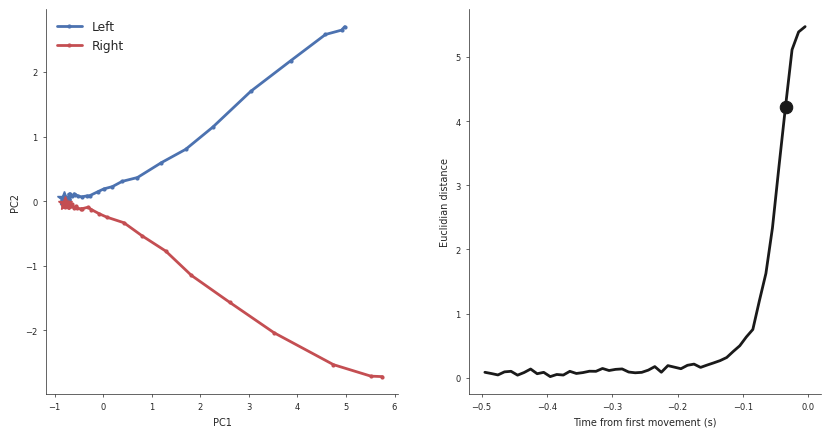

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the trajectories
axs[0].plot(traj_left[0, :], traj_left[1, :], color='b', label='Left',  marker='.', lw=2)
axs[0].plot(traj_right[0, :], traj_right[1, :], color='r', label='Right',  marker='.', lw=2)
# Mark the start
axs[0].plot(traj_left[0, 0], traj_left[1, 0], color='b', marker='*', ms=10)
axs[0].plot(traj_right[0, 0], traj_right[1, 0], color='r', marker='*', ms=10)
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].legend(loc=2, frameon=False)

axs[1].plot(meta.times[time_window], euc_dist, color='k', lw=2)
axs[1].scatter(latency, euc_dist[latency_idx], color='k', s=80)
axs[1].set_xlabel('Time from first movement (s)')
axs[1].set_ylabel('Euclidian distance')

### **Decoding choice from neural activity**

In this section, we will explore whether we can **predict the mouse's choice** (i.e. left or right movement) based on neural activity using **trial-level PSTH data**.

Unlike the previous analyses, which averaged firing rates across trials, we will need to have access to the data on the individual trial level. To facilitate this, we provide three helper functions that return the trial-level data:

* `get_psth_for_insertion`
* `get_psth_for_region`
* `get_psth_for_clusters`


The function **`get_psth_for_insertion`** loads trial-level data for a specified pid. The function returns three objects:

1. A 3D array of shape `n_trials x n_clusters x n_times` containing the PSTH for the specified pid

2. A dataframe describing the clusters for the specified pid

3. A dataframe describing the trials for the specified pid


In [ ]:
pid = '8ca1a850-26ef-42be-8b28-c2e2d12f06d6'
psth, clust_df, trials_df = get_psth_for_insertion('8ca1a850-26ef-42be-8b28-c2e2d12f06d6', meta)

print(psth.shape)
print(len(clust_df))
print(len(trials_df))

(569, 172, 150)
172
569


The functions **`get_psth_for_region`** and **`get_psth_for_clusters`** return lists of PSTH arrays, cluster metadata, and trial tables, each corresponding to one probe insertion.

For example, the region VISam has data from 23 separate insertions, so the lists will have length 23.

In [ ]:
psth, clust_reg, trials_reg = get_psth_for_region('VISam', meta)

print(len(psth))
print(len(clust_reg))
print(len(trials_reg))

23
23
23


We will now demonstrate how to decode the mouse's choice. As choice is a **binary variable (+1, -1)** we will use **logistic regression** on the activity of all clusters from a single insertion.

In [ ]:
psth, clust_df, trials_df = get_psth_for_insertion('8ca1a850-26ef-42be-8b28-c2e2d12f06d6', meta)

time_mask = np.bitwise_and(meta.times < 0, meta.times > -0.1)
X = psth[:, :, time_mask].mean(axis=2)
y = trials_df.choice.values

# Split trials in half into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Fit the logistic regression model
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

# Use the test set to assess the model accuracy
choice_predicted = clf.predict(X_test)
n_trial_correct = (y_test == choice_predicted).sum()
print(f'{n_trial_correct}/{len(y_test)} trials correctly predicted')
print(f'Accuracy: {np.round(n_trial_correct/len(y_test), 2) * 100} %')


225/285 trials correctly predicted
Accuracy: 79.0 %


🟨 **Note**
* In this example, we used a 50/50 train-test split. For a more robust estimate of model performance, you could use leave-one-out cross-validation. This involves training the model on all trials except one, predicting the held-out trial, and repeating for each trial, maximizing the amount of training data used in each iteration.


## **6. Example of a brainwide analysis**

In this section, we will walk through how to extend your analysis across **all brain regions** included in the dataset. For example, suppose we want to identify which regions are **most responsive to stimulus onset**. To do this, we will return to the **modulation index (MI)** metric introduced earlier, using it to quantify and compare the number of responsive clusters in each region.



In [ ]:
# Get meta data for stimulus onset
meta = load_metadata('stimOn')
# Find the regions contained in our dataset
regions = meta.clusters['acronym'].unique()

In [ ]:
# Define pre and post window timepoints
pre_time = [-0.3, -0.25]
post_time = [0.05, 0.1]
pre_time_idx = np.bitwise_and(meta['times'] >= pre_time[0], meta['times'] <= pre_time[1])
post_time_idx = np.bitwise_and(meta['times'] >= post_time[0], meta['times'] <= post_time[1])

# Define threshold to detect responsive cells
threshold = 0.3


# Loop over the regions and compute the modulation index for all cells
all_modulated = []
for reg in regions:
  # Ignore root and void where clusters are unassigned
  if reg in ['root', 'void']:
    continue
  psth, df = get_avg_psth_for_region(reg, meta)
  df['pre'] = np.mean(psth[:, pre_time_idx], axis=1)
  df['post'] = np.mean(psth[:, post_time_idx], axis=1)
  df['modulation_idx'] = (df['pre'] - df['post']).abs() / (df['pre'] + df['post']).abs()
  df['modulated'] = np.bitwise_and(df['modulation_idx'] >= threshold, df['modulation_idx'] < 1)

  all_modulated.append(df)

# Concatenate results into a single dataframe
all_modulated = pd.concat(all_modulated)

We can then group the data by brain region to create a new DataFrame that summarizes, for each region, both the **percentage of responsive clusters** and the **total number of clusters** recorded.

In [ ]:
res = pd.DataFrame()
res['percentage'] = all_modulated.groupby('acronym')['modulated'].sum() / all_modulated.groupby('acronym')['modulated'].count()
res['n_clusters'] = all_modulated.groupby('acronym')['modulated'].count()

We will plot the top 20 brain regions with the largest percentage of clusters with a high modulation index.

Text(0, 0.5, 'Percentage of responsive clusters')

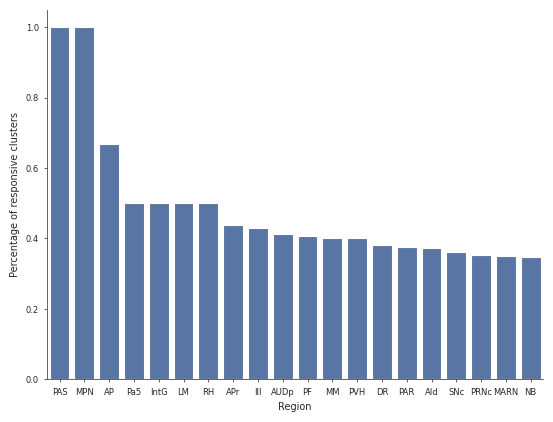

In [ ]:
res_sort = res.sort_values('percentage', ascending=False)
n_reg = 20
fig, ax = plt.subplots()
sns.barplot(x='acronym', y='percentage', data=res_sort[0:n_reg], ax=ax)
ax.set_xlabel('Region')
ax.set_ylabel('Percentage of responsive clusters')

Note that, so far, we have included all brain regions without applying any filters based on the number of recorded clusters or their firing rates. As a result, some regions may appear to have a high percentage of modulated cells simply because they contain very few clusters, which can be misleading.

To obtain more robust results, we will now **restrict our analysis** to regions that have **more than 200 recorded clusters**. This will allow us to more reliably identify regions with the highest number of responsive cells.

Text(0, 0.5, 'Percentage of responsive cells')

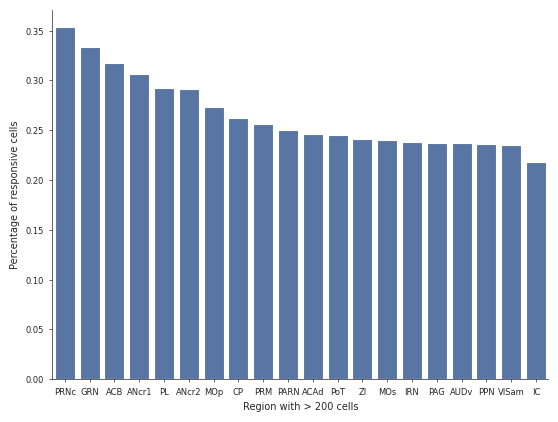

In [ ]:
n_clust = 200
res_filt = res[res['n_clusters'] >= n_clust]
res_sort = res_filt.sort_values('percentage', ascending=False)
n_reg = 20

fig, ax = plt.subplots()
sns.barplot(x='acronym', y='percentage', data=res_sort[0:n_reg], ax=ax)
ax.set_xlabel('Region with > 200 cells')
ax.set_ylabel('Percentage of responsive cells')

The top five regions with the highest proportion of responsive clusters are **PRNc**, **GRN**, **ACB**, **ANcr1**, and **ANcr2**, each with over **25%** of clusters showing significant modulation in response to stimulus onset.

This observation aligns well with findings from the [International Brain Lab paper](https://doi.org/10.1101/2023.07.04.547681).

📔 *A Brain-Wide Map of Neural Activity during Complex Behaviour - International Brain Laboratory et al.*



In particular, most of these regions are consistently identified as being responsive to visual stimuli across at least **three out of four** independent analysis methods presented in the study.

Below is a snapshot of Figure 5 from the paper, with **PRNc** and **GRN** highlighted.

![](https://ibl-brain-wide-map-public.s3.us-east-1.amazonaws.com/sample_data/Neuromatch/figures/stimulus_bwm.png)

## **7. Exploring the block variable**

In this section, we will study how the mice are able to track the **block prior** (i.e. the probability of the visual stimulus to appear most likely on one side of the screen). As the block change is not cued, mice have to **integrate** over the past trials. We will review the literature showing this temporal integration, and perform a decoding analysis at different timepoints (early or late) in blocks.


We will review plots from Fig 1 of [this article](https://doi.org/10.1101/2023.07.04.547684):

📔 *Brain-wide representations of prior information in mouse
decision-making - Findling, Hubert, International Brain Laboratory et al.*



As a reminder, during the task the contrast of the visual stimulus changes, ranging from 100% (fully visible) to 0% (invisible).


In addition, the probability of the stimulus appearing on the left side of the screen varies in blocks of trials.



![](https://ibl-brain-wide-map-public.s3.us-east-1.amazonaws.com/sample_data/Neuromatch/figures/task_recap.png)

The mice can use this probability information to attempt to obtain rewards even during 0% contrast trials, when no visual stimulus is present on the screen.

This strategy is evident in their psychometric curves: on 0% contrast trials, mice tend to bias their responses toward the side associated with the current block.

This bias is weaker during 100% contrast trials, where the stimulus is clearly visible and mice are able to make accurate choices with high reliability.

![](https://ibl-brain-wide-map-public.s3.us-east-1.amazonaws.com/sample_data/Neuromatch/figures/biased_performance.png)

**But how do they know which block they are in?**

Since the block switches are not cued, an observer would need to integrate information over several past trials to form a prior about the current block identity.

We can see that mice do such integration, as shown by their performance on 0% contrast trials over the course of a block.

*   On `early` trials within a block, mice tend to perform poorly.
*   On `later` trials, their performance improves, indicating a growing certainty about the block identity.

![](https://ibl-brain-wide-map-public.s3.us-east-1.amazonaws.com/sample_data/Neuromatch/figures/trial_early_late_block.png)

We can replicate this result with our trials table data and using the columns `block` and `block_trial_number` to find examples of these **`early` (<= 2 trials since block change)** and **`late` (> 15 trials since block change)** trials for **0 % and 100 % contrast** stimuli.

In [ ]:
# Load in meta data that has the trials table
meta = load_metadata('stimOn')
trials = meta.trials

We will add three new columns to our trials table
* `contrast` the absolute contrast of the visual stimulus
* `correct` the correct trials

and
* `block_timing` where we annotate the first 0 or 100 % trial that matches the `early` or `late` trial type condition



In [ ]:
trials = trials.assign(contrast=np.nansum([trials['contrastLeft'], trials['contrastRight']], axis=0))
trials = trials.assign(correct=trials['feedbackType'] == 1)

queries = []
# early trials with 0% contrast
queries.append('block_trial_number <= 2 and contrast == 0 and probabilityLeft != 0.5')
# early trials with 100% contrast
queries.append('block_trial_number <= 2 and contrast == 1 and probabilityLeft != 0.5')
# late trials with 0% contrast
queries.append('block_trial_number > 15 and contrast == 0 and probabilityLeft != 0.5')
# late trials with 100% contrast
queries.append('block_trial_number > 15 and contrast == 1 and probabilityLeft != 0.5')

trial_type = ['Early', 'Early', 'Late', 'Late']

for query, val in zip(queries, trial_type):
  idx = trials.query(query).drop_duplicates(subset=['eid', 'block'], keep='first')
  mask = trials.index.isin(idx.index)
  trials.loc[mask, 'block_timing'] = val

# Remove nan trials
trials = trials[~trials['block_timing'].isna()]

We can then group by `block_timing` and `contrast` and compute the proportion of trials that were correct for each condition

In [ ]:
trials_grp = trials.groupby(['block_timing', 'contrast'])
prop_correct = trials_grp['correct'].mean()

for grp, p in prop_correct.items():
    print(f'{grp}: {np.round(p * 100, 2)}')

('Early', 0.0): 42.18
('Early', 1.0): 97.62
('Late', 0.0): 62.72
('Late', 1.0): 98.45


This aligns well with the plot above, which shows that the mice's performance on 0% contrast trials improves depending on when the trial occurs relative to the block switch. Performance is lower immediately after a block change and increases as more trials pass within the new block.

We can also see if we are able to decode block from a single recording. We will chooses a time window of between **0.3 to 0.1 ms prior to visual stimulus onset**.

In [ ]:
psth, clust_df, trials_df = get_psth_for_insertion('8ca1a850-26ef-42be-8b28-c2e2d12f06d6', meta)

time_mask = np.bitwise_and(meta.times < -0.1, meta.times > -0.3)
X = psth[:, :, time_mask].mean(axis=2)
# Convert values of 0.2, 0.5, 0.8 to 1, 2, 3 for logistic regression
mapping = {0.2: 1, 0.5: 2, 0.8: 3}
y = trials_df['probabilityLeft'].map(mapping).values

# Split trials in half into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Fit the logistic regression model
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

# Use the test set to assess the model accuracy
choice_predicted = clf.predict(X_test)
n_trial_correct = (y_test == choice_predicted).sum()
print(f'{n_trial_correct}/{len(y_test)} trials correctly predicted')
print(f'Accuracy: {np.round(n_trial_correct/len(y_test), 2) * 100} %')

182/285 trials correctly predicted
Accuracy: 64.0 %


### **Going further - Bayes Optimal model**

Mice may use various strategies to perform temporal integration and form a prior about the current block. However, one thing is clear, they are not able to detect block switches as sharply as the actual block transitions occur.

If we use an ideal observer model, known as the **Bayes-optimal model**, the confidence in the block identity would follow the blue curve shown below:


![](https://ibl-brain-wide-map-public.s3.us-east-1.amazonaws.com/sample_data/Neuromatch/figures/block_bayes_optimal.png)

In other words, it is not feasible to decode the block identity exactly as it is defined in the task, as attempted above, because the block switches are uncued. Instead, the most accurate estimate an animal could form about the current block is described by the Bayes-optimal prior.

A more realistic approach, therefore, is to decode this Bayes-optimal prior from neural activity, rather than attempting to decode the true block variable directly from the task design.

You can find an example of how to compute the Bayes-optimal prior and decode it using neural activity from a single session in this [notebook](https://github.com/int-brain-lab/prior-localization/blob/main/prior_localization/decode_single_session.ipynb).


🟨 **Note**
* This analysis requires access to the full dataset, rather than the pre-processed version used above. To get started with accessing the full IBL dataset, please refer to:
  *   [This introductary notebook](https://colab.research.google.com/drive/1_1qfa-DLDbezyFXguFOnJJWF5aJ5AH0i#scrollTo=-TJR7XEgtBxS)
  *   [This tutorial](https://colab.research.google.com/drive/1y3sRI1wC7qbWqN6skvulzPOp6xw8tLm7#scrollTo=hRZA78AoaBIC)


The `Bayes Optimal` model is really the best an animal could do in estimating the block prior. However, mice are likely not that optimal.

The [article](https://doi.org/10.1101/2023.07.04.547684) introduces alternative models that better capture actual mouse behavior, such as the `Action Kernel` model, which incorporates a memory of past actions.

All behavioral models discussed in the paper are available in this [repository](https://github.com/int-brain-lab/behavior_models/tree/main).

### **Going further - Exploring behaviour**

There are many more questions related to block that we can explore related using the behavioral data. Here are a few example questions:

1. 🔍 Take a trial, and look at the values for contrast and block on the previous `N` trials. Consider the contrast as your certainty measure,
meaning for a 100% contrast trial you are sure of the associated block side.

  Given this information, what would be your predicted block side for your current trial? And how correct would you be? How does that vary with `N` size?

2. 🔍  Does the reaction time changes on trials when the visual stimulus appears on the other side than the expected block prior?
Does this effect vary with stimulus contrast?

These can be explored either by using the data prepared for this course of by accessing the [full behavioural dataset](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/projects/behavior/IBL_behavior_data.ipynb) that is available as part of the behavioural project datasets.